In [187]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Sequential, load_model,Model
import numpy as np
from tensorflow.keras.losses import categorical_crossentropy as cce
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.utils import to_categorical

import h5py
from sklearn import utils
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn import metrics


In [2]:
right_images = np.load('20200514_right__Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.npy')

In [129]:
new_left_images = []
new_left_labels = []
new_right_images = []
new_right_labels = []


for img in right_images:
    new_left_images.append(np.fliplr(img))
    new_left_labels.append([0,1])
    new_right_images.append(img)
    new_right_labels.append([1,0])
new_left_images = np.array(new_left_images)
new_right_images = np.array(new_right_images)

split = int(0.2*95)

right_img_shuff, right_label_shuff = utils.shuffle(new_right_images[:191], new_right_labels[:191],random_state=0)
left_img_shuff, left_label_shuff = utils.shuffle(new_left_images[:191], new_left_labels[:191],random_state=0)

X_trainA = np.concatenate((right_img_shuff[:95],left_img_shuff[:95]),axis =0)
Y_trainA = np.concatenate((left_label_shuff[:split],right_label_shuff[split:95],right_label_shuff[:split],left_label_shuff[split:95]),axis = 0)
X_trainB = np.concatenate((right_img_shuff[95:-1],left_img_shuff[95:-1]),axis =0)
Y_trainB = np.concatenate((left_label_shuff[:split],right_label_shuff[split:95],right_label_shuff[:split],left_label_shuff[split:95]),axis = 0)


right_img_shuff, right_label_shuff = utils.shuffle(new_right_images[191:286], new_right_labels[191:286],random_state=0)
left_img_shuff, left_label_shuff = utils.shuffle(new_left_images[191:286], new_left_labels[191:286],random_state=0)

split = int(0.2*47)

X_testA = np.concatenate((right_img_shuff[:47],left_img_shuff[:47]),axis = 0)
Y_testA = np.concatenate((left_label_shuff[:split],right_label_shuff[split:47],right_label_shuff[:split],left_label_shuff[split:47]),axis = 0)
correct_testA = np.concatenate((right_label_shuff[47:-1],left_label_shuff[47:-1]),axis = 0)
X_testB = np.concatenate((right_img_shuff[47:-1],left_img_shuff[47:-1]),axis = 0)
Y_testB = np.concatenate((left_label_shuff[:split],right_label_shuff[split:47],right_label_shuff[:split],left_label_shuff[split:47]),axis = 0)
correct_testB = np.concatenate((right_label_shuff[47:-1],left_label_shuff[47:-1]),axis = 0)

X_trainA = X_trainA/X_trainA.max()
X_testA = X_testA/X_testA.max()
X_trainB= X_trainB/X_trainB.max()
X_testB = X_testB/X_testB.max()

X_trainA = np.expand_dims(X_trainA,axis=3)
X_testA = np.expand_dims(X_testA,axis=3)
X_trainB = np.expand_dims(X_trainB,axis=3)
X_testB = np.expand_dims(X_testB,axis=3)

X_trainA, Y_trainA = utils.shuffle(X_trainA, Y_trainA,random_state=0)
X_testA, Y_testA, correct_testA = utils.shuffle(X_testA, Y_testA, correct_testA,random_state=0)
X_trainB,Y_trainB = utils.shuffle(X_trainB, Y_trainB,random_state=0)
X_testB, Y_testB, correct_testB = utils.shuffle(X_testB, Y_testB, correct_testB, random_state=0)

In [48]:
X_trainA.shape[0]*200//25

1520

In [161]:
batch_size = 25
seed = 42
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=False,
        vertical_flip = False)

test_datagen = ImageDataGenerator(rescale=1.)

train_generatorA = train_datagen.flow(X_trainA.repeat(300,axis=0), y=np.array(Y_trainA).repeat(300,axis=0), batch_size=batch_size,seed=seed)
val_generatorA = test_datagen.flow(X_testA.repeat(300,axis=0),y=Y_testA.repeat(300,axis=0),batch_size=batch_size,seed=seed)
train_generatorB = train_datagen.flow(X_trainB.repeat(250,axis=0), y=Y_trainB.repeat(250,axis=0), batch_size=batch_size,seed=seed)
val_generatorB = test_datagen.flow(X_testB.repeat(300,axis=0),y=Y_testB.repeat(300,axis=0),batch_size=batch_size,seed=seed)

In [152]:
del modelA
del modelB
clear_session()

In [153]:
modelA = keras.models.Sequential()
modelA.add(Conv2D(42, (3, 3), input_shape=(128, 128,1)))
modelA.add(Activation('relu'))
modelA.add(MaxPooling2D(pool_size=(2, 2)))
modelA.add(Conv2D(42, (3, 3)))
modelA.add(Activation('relu'))
modelA.add(MaxPooling2D(pool_size=(2, 2)))

modelA.add(Conv2D(74, (3, 3)))
modelA.add(Activation('relu'))
modelA.add(MaxPooling2D(pool_size=(2, 2)))

modelA.add(Conv2D(74, (3, 3)))
modelA.add(Activation('relu'))
modelA.add(MaxPooling2D(pool_size=(2, 2)))

modelA.add(Conv2D(74, (3, 3)))
modelA.add(Activation('relu'))
modelA.add(MaxPooling2D(pool_size=(2, 2)))

modelA.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelA.add(Dense(74))
modelA.add(Activation('relu'))
modelA.add(Dropout(0.5))
modelA.add(Dense(2))
modelA.add(Activation('softmax'))

modelA.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

modelB = keras.models.Sequential()
modelB.add(Conv2D(22, (3, 3), input_shape=(128, 128,1)))
modelB.add(Activation('relu'))
modelB.add(MaxPooling2D(pool_size=(2, 2)))

modelB.add(Conv2D(22, (3, 3)))
modelB.add(Activation('relu'))
modelB.add(MaxPooling2D(pool_size=(2, 2)))

modelB.add(Conv2D(54, (3, 3)))
modelB.add(Activation('relu'))
modelB.add(MaxPooling2D(pool_size=(2, 2)))

modelB.add(Conv2D(54, (3, 3)))
modelB.add(Activation('relu'))
modelB.add(MaxPooling2D(pool_size=(2, 2)))

modelB.add(Conv2D(54, (3, 3)))
modelB.add(Activation('relu'))
modelB.add(MaxPooling2D(pool_size=(2, 2)))

modelB.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelB.add(Dense(54))
modelB.add(Activation('relu'))
modelB.add(Dropout(0.5))
modelB.add(Dense(2))
modelB.add(Activation('softmax'))

modelB.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [162]:
del modelA

In [163]:
modelA = keras.models.Sequential()
modelA.add(Conv2D(32, (3, 3), input_shape=(128, 128,1)))
modelA.add(Activation('relu'))
modelA.add(MaxPooling2D(pool_size=(2, 2)))
modelA.add(Conv2D(32, (3, 3)))
modelA.add(Activation('relu'))
modelA.add(MaxPooling2D(pool_size=(2, 2)))

modelA.add(Conv2D(64, (3, 3)))
modelA.add(Activation('relu'))
modelA.add(MaxPooling2D(pool_size=(2, 2)))

modelA.add(Conv2D(64, (3, 3)))
modelA.add(Activation('relu'))
modelA.add(MaxPooling2D(pool_size=(2, 2)))

modelA.add(Conv2D(64, (3, 3)))
modelA.add(Activation('relu'))
modelA.add(MaxPooling2D(pool_size=(2, 2)))

modelA.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelA.add(Dense(64))
modelA.add(Activation('relu'))
modelA.add(Dropout(0.5))
modelA.add(Dense(2))
modelA.add(Activation('softmax'))

modelA.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])


In [164]:
historyA = modelA.fit_generator(
        train_generatorA,
        steps_per_epoch=2500,
        epochs=1,
        validation_data=val_generatorA,
        validation_steps=100,
        verbose = 2)

2280/2500 - 405s - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5008


In [87]:
historyB = modelB.fit_generator(
        train_generatorB,
        steps_per_epoch=1000,
        epochs=3,
        validation_data=val_generatorB,
        validation_steps=100,
        verbose = 2)

Epoch 1/3
1000/1000 - 142s - loss: 0.3609 - accuracy: 0.8087 - val_loss: 0.2584 - val_accuracy: 0.9040
Epoch 2/3
1000/1000 - 138s - loss: 0.0347 - accuracy: 0.9891 - val_loss: 0.7054 - val_accuracy: 0.8460
Epoch 3/3
1000/1000 - 141s - loss: 0.0188 - accuracy: 0.9945 - val_loss: 0.0350 - val_accuracy: 0.9908


In [88]:
modelB.save_weights('20200921_suprise_amazingnet.h5')

In [157]:
historyB = modelB.fit_generator(
        train_generatorB,
        steps_per_epoch=1500,
        epochs=1,
        validation_data=val_generatorB,
        validation_steps=100,
        verbose = 2)

1500/1500 - 201s - loss: 0.6305 - accuracy: 0.6066 - val_loss: 0.6796 - val_accuracy: 0.6664


In [207]:
historyB2 = modelB2.fit_generator(
        train_generatorA,
        steps_per_epoch=1500,
        epochs=2,
        validation_data=val_generatorA,
        validation_steps=100,
        verbose = 2)

Epoch 1/2
1500/1500 - 200s - loss: 0.6933 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4928
Epoch 2/2
1500/1500 - 201s - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6934 - val_accuracy: 0.4932


In [204]:
modelB2 = keras.models.Sequential()
modelB2.add(Conv2D(22, (3, 3), input_shape=(128, 128,1)))
modelB2.add(Activation('relu'))
modelB2.add(MaxPooling2D(pool_size=(2, 2)))

modelB2.add(Conv2D(22, (3, 3)))
modelB2.add(Activation('relu'))
modelB2.add(MaxPooling2D(pool_size=(2, 2)))

modelB2.add(Conv2D(54, (3, 3)))
modelB2.add(Activation('relu'))
modelB2.add(MaxPooling2D(pool_size=(2, 2)))

modelB2.add(Conv2D(54, (3, 3)))
modelB2.add(Activation('relu'))
modelB2.add(MaxPooling2D(pool_size=(2, 2)))

modelB2.add(Conv2D(54, (3, 3)))
modelB2.add(Activation('relu'))
modelB2.add(MaxPooling2D(pool_size=(2, 2)))

modelB2.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelB2.add(Dense(54))
modelB2.add(Activation('relu'))
modelB2.add(Dropout(0.5))
modelB2.add(Dense(2))
modelB2.add(Activation('softmax'))

modelB2.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [101]:
split = int(0.2*47)

X_testA = np.concatenate((right_img_shuff[:47],left_img_shuff[:47]),axis = 0)
Y_testA = np.concatenate((left_label_shuff[:split],right_label_shuff[split:47],right_label_shuff[:split],left_label_shuff[split:47]),axis = 0)
X_testB = np.concatenate((right_img_shuff[47:-1],left_img_shuff[47:-1]),axis = 0)
Y_testB = np.concatenate((left_label_shuff[:split],right_label_shuff[split:47],right_label_shuff[:split],left_label_shuff[split:47]),axis = 0)
X_testA = X_testA/X_testA.max()
X_testB = X_testB/X_testB.max()
X_testA = np.expand_dims(X_testA,axis=3)
X_testB = np.expand_dims(X_testB,axis=3)


In [102]:
X_testB.shape

(94, 128, 128, 1)

In [103]:
modelA.predict(X_testB[:10])

array([[9.9999356e-01, 6.3872599e-06],
       [6.2683332e-01, 3.7316674e-01],
       [9.5418113e-01, 4.5818899e-02],
       [1.0000000e+00, 5.3852389e-09],
       [9.9999464e-01, 5.3464601e-06],
       [9.9900889e-01, 9.9108799e-04],
       [1.0000000e+00, 4.2036405e-08],
       [9.9999654e-01, 3.4017048e-06],
       [7.2878718e-01, 2.7121285e-01],
       [9.9999964e-01, 4.0980251e-07]], dtype=float32)

In [106]:
Y_testB[:10]


array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0]])

In [165]:
B= modelB.predict(X_testA[:10])


In [192]:
A=model.predict(X_testA[:10])


In [166]:
cce(Y_testA[:10],B)


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.4379987 , 0.18802424, 0.13179591, 0.44081765, 0.03533849,
       0.08124394, 0.86379886, 0.26602122, 0.0507086 , 0.06702727],
      dtype=float32)>

In [193]:
cce(Y_testA[:10],A)


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.6118095e+01, 1.1920929e-07, 1.1920929e-07, 1.1920929e-07,
       1.1920929e-07, 1.1920929e-07, 1.1920929e-07, 1.1920929e-07,
       1.6118095e+01, 1.1920929e-07], dtype=float32)>

In [202]:
cce(np.array([[1,0]],dtype='float32'),np.array([[0.5,0.5]],dtype='float32'))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.6931472], dtype=float32)>

In [169]:
B

array([[0.35467336, 0.6453266 ],
       [0.8285946 , 0.1714054 ],
       [0.12348013, 0.87651986],
       [0.64351004, 0.35649002],
       [0.96527874, 0.03472132],
       [0.07803123, 0.9219687 ],
       [0.5784424 , 0.4215576 ],
       [0.23357715, 0.7664228 ],
       [0.9505556 , 0.04944438],
       [0.06483027, 0.9351697 ]], dtype=float32)

In [195]:
A

array([[1.0000000e+00, 2.2607824e-32],
       [1.0000000e+00, 1.1827928e-35],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 3.5047649e-38],
       [3.8423028e-25, 1.0000000e+00],
       [4.5789402e-18, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [9.9196236e-20, 1.0000000e+00],
       [1.0461702e-10, 1.0000000e+00]], dtype=float32)

In [170]:
Y_testA[:10]

array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1]])

In [171]:
correct_testA[:10]

array([[1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1]])

In [175]:
metrics.accuracy_score(Y_testA[:10],B>0.55)

0.9

In [176]:
metrics.accuracy_score(correct_testA[:10],B>0.55)

0.8

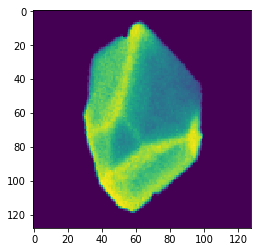

In [196]:
plt.imshow(X_testA[8,:,:,0])

In [188]:
def down(filters, input_):
    down_ = Conv2D(filters, (3, 3))(input_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2))(down_)
    return down_pool

def final_stack(input1_):
    flat = Flatten()(input1_)
    dense1 = Dense(64*2)(flat)
    act1 = Activation('relu')(dense1)
    drop = Dropout(0.5)(act1)
    dense2 = Dense(2)(drop)
    act2 = Activation('softmax')(dense2)
    return act2


def first_cnn(input_):
    down1 = down(32*2,input_)
    down2 = down(32*2,down1)
    down3 = down(64*2,down2)
    down4 = down(64*2,down3)
    down5 = down(64*2,down4)
    # final = first_final_stack(down5)
    return down5

def complete_model(input_shape):
    input1 = Input(shape=input_shape)
    final1 = first_cnn(input1)
    final = final_stack(final1)
    model = Model(inputs=input1, outputs=final)
    return model

model = complete_model((128, 128,1))

model.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])

In [189]:
model.load_weights('savio_nets/rcnnV1_counternet_20pwrongleftrightlabels_weights_20200821.h5')

In [126]:
B[8]


array([9.9999976e-01, 2.4198766e-07], dtype=float32)

In [127]:
A[8]

array([0.98725116, 0.01274881], dtype=float32)

In [104]:
split

9

In [90]:
list(historyA.history.keys())

['loss', 'accuracy', 'val_loss', 'val_accuracy']

In [91]:
historyB.history['accuracy'][:]

[0.80867999792099, 0.989080011844635, 0.9945200085639954]

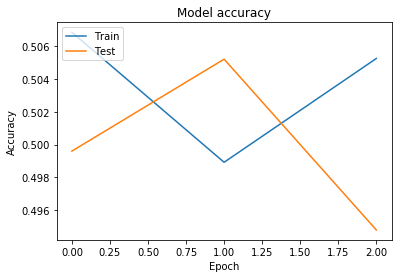

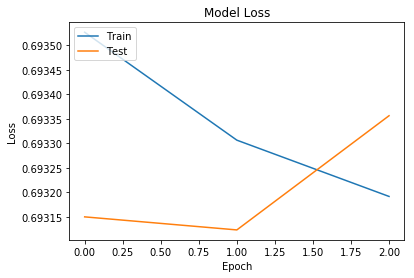

In [136]:
plt.plot(historyA.history['accuracy'][:])
plt.plot(historyA.history['val_accuracy'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(historyA.history['loss'])
plt.plot(historyA.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

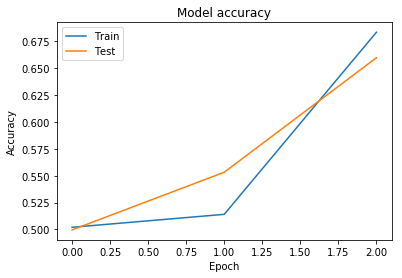

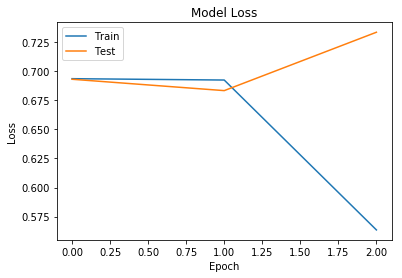

In [137]:
plt.plot(historyB.history['accuracy'][:])
plt.plot(historyB.history['val_accuracy'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [68]:
X_testA.shape

(94, 128, 128, 1)

In [69]:
modelB.predict(X_testA[:10])

array([[1.0000000e+00, 7.1300787e-09],
       [1.0000000e+00, 5.3328023e-13],
       [1.1577945e-11, 1.0000000e+00],
       [1.0000000e+00, 3.6247514e-09],
       [1.0000000e+00, 1.0967026e-15],
       [6.4149714e-07, 9.9999940e-01],
       [1.6630494e-09, 1.0000000e+00],
       [6.1590715e-12, 1.0000000e+00],
       [1.0000000e+00, 2.8206798e-11],
       [4.3512890e-07, 9.9999952e-01]], dtype=float32)

In [70]:
Y_testA[:10]

array([[1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1]])

In [71]:
modelA.predict(X_testB[:10])

array([[9.9518049e-01, 4.8195822e-03],
       [9.9999928e-01, 7.6994183e-07],
       [1.7041018e-06, 9.9999833e-01],
       [9.9817371e-01, 1.8262628e-03],
       [9.9778521e-01, 2.2147400e-03],
       [3.3923923e-05, 9.9996603e-01],
       [7.0815361e-01, 2.9184639e-01],
       [1.2889745e-05, 9.9998713e-01],
       [9.9989605e-01, 1.0394705e-04],
       [3.4412491e-04, 9.9965584e-01]], dtype=float32)

In [74]:
Y_testB[:10]

array([[1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1]])

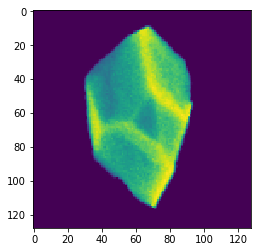

In [75]:
plt.imshow(X_testB[-4,:,:,0])

In [76]:
modelA.evaluate(X_testB,Y_testB)


3/3 [==============================] - 0s 32ms/step - loss: 0.1908 - accuracy: 0.9043


[0.1907595992088318, 0.9042553305625916]

In [77]:
modelB.evaluate(X_testA,Y_testA)


3/3 [==============================] - 0s 27ms/step - loss: 0.9667 - accuracy: 0.8511


[0.9667279124259949, 0.8510638475418091]

In [78]:
modelA.evaluate(X_testA,Y_testA)


3/3 [==============================] - 0s 33ms/step - loss: 0.7376 - accuracy: 0.8404


[0.7376053929328918, 0.8404255509376526]